In [106]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
import json
from source import *
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

import scienceplots

plt.style.use(['science','ieee', 'grid'])

In [107]:
lep = ds.dataset(list(Path(f"halfleptonic/").glob("*.parquet")), format="parquet")

In [108]:
scanner = lep.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    display(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'pmiss', 'cmpmiss', 'thetamiss',
       'cmthetamiss', 'fox', 'asymmetry', 'p0', 'theta_Bs', 'M0', 'recM2_Bs',
       'idec0', 'idec1', 'is0', 'N_KL', 'Miss_id_0', 'Miss_id_1', 'Bs_lik',
       'N_KS', 'theta_tau_0', 'p_tau_0', 'theta_tau_1', 'p_tau_1', 'tau_d_0_0',
       'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0', 'tau_last_z_1',
       'tau_last_r_1', 'Istau0', 'Istau1', 'Chi_sq_0', 'Chi_sq_1', 'dr0',
       'dr1', 'totalEnergyMC', 'E_gamma_in_ROE', 'correct_nu_0',
       'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1', 'lost_0',
       'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1',
       'PID_self_vs_1_tau1', 'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')

In [109]:
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012)
mask_M = (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask1 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 1) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387) 
mask0 = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("is0") == 0) & (pc.field("Bs_lik") > 0.0012) &  (pc.field("M0") > 5.347) &  (pc.field("M0") < 5.387)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))
mask_miss_id = pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_lost_Kpi = pc.field("lost_0") & pc.field("lost_1")
mask_KS_veto = (pc.field("N_KS") == 0) & (pc.field("N_KL") == 0)

In [110]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_7936\1033810642.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [111]:
import json
with open("columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [112]:
data = get_values(lep, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1) & mask_is1))

Total data size: 0.04 MB


In [113]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

In [114]:
BS0 = 5.366691

In [115]:
wbin_x, a_x, b_x = 0.05, 0, 1.2
wbin_y, a_y, b_y = 0.005, BS0-0.2, BS0+0.2

bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))

In [116]:
from pyarrow import dataset as ds
from pyarrow import compute as pc
from pyarrow import Table
from typing import Union, List, Optional, Tuple
import numpy as np

def compute_nd_histogram(
    dataset: ds.Dataset,
    bins: Union[np.ndarray, List[np.ndarray]],
    targets: Union[str, List[str]],
    fun=lambda x: x,
    filter_mask: Optional[pc.Expression] = None,
    norm: bool = False,
    nanto: float = np.nan
) -> Tuple[List[np.ndarray], np.ndarray, int]:
    if isinstance(targets, str):
        targets = [targets]

    if isinstance(bins, np.ndarray):
        bins = [bins] * len(targets)

    bin_centers = [0.5 * (b[:-1] + b[1:]) for b in bins]
    hist_counts = np.zeros_like(np.meshgrid(*bin_centers, indexing='ij')[0])
    scanner = dataset.scanner(batch_size=100_000, filter=filter_mask)

    for batch in scanner.to_batches():
        table = Table.from_batches([batch])
        df = table.select(targets).to_pandas()
        df = df.fillna(nanto)
        values = df.values

        counts, _ = np.histogramdd(values, bins=bins)
        hist_counts += counts

    total_events = int(np.sum(hist_counts))

    # Вычисляем центры биннов по каждой оси

    if norm and total_events > 0:
        hist_counts /= total_events
    bin_centers = np.meshgrid(*bin_centers, indexing='ij')
    return bin_centers, hist_counts, total_events


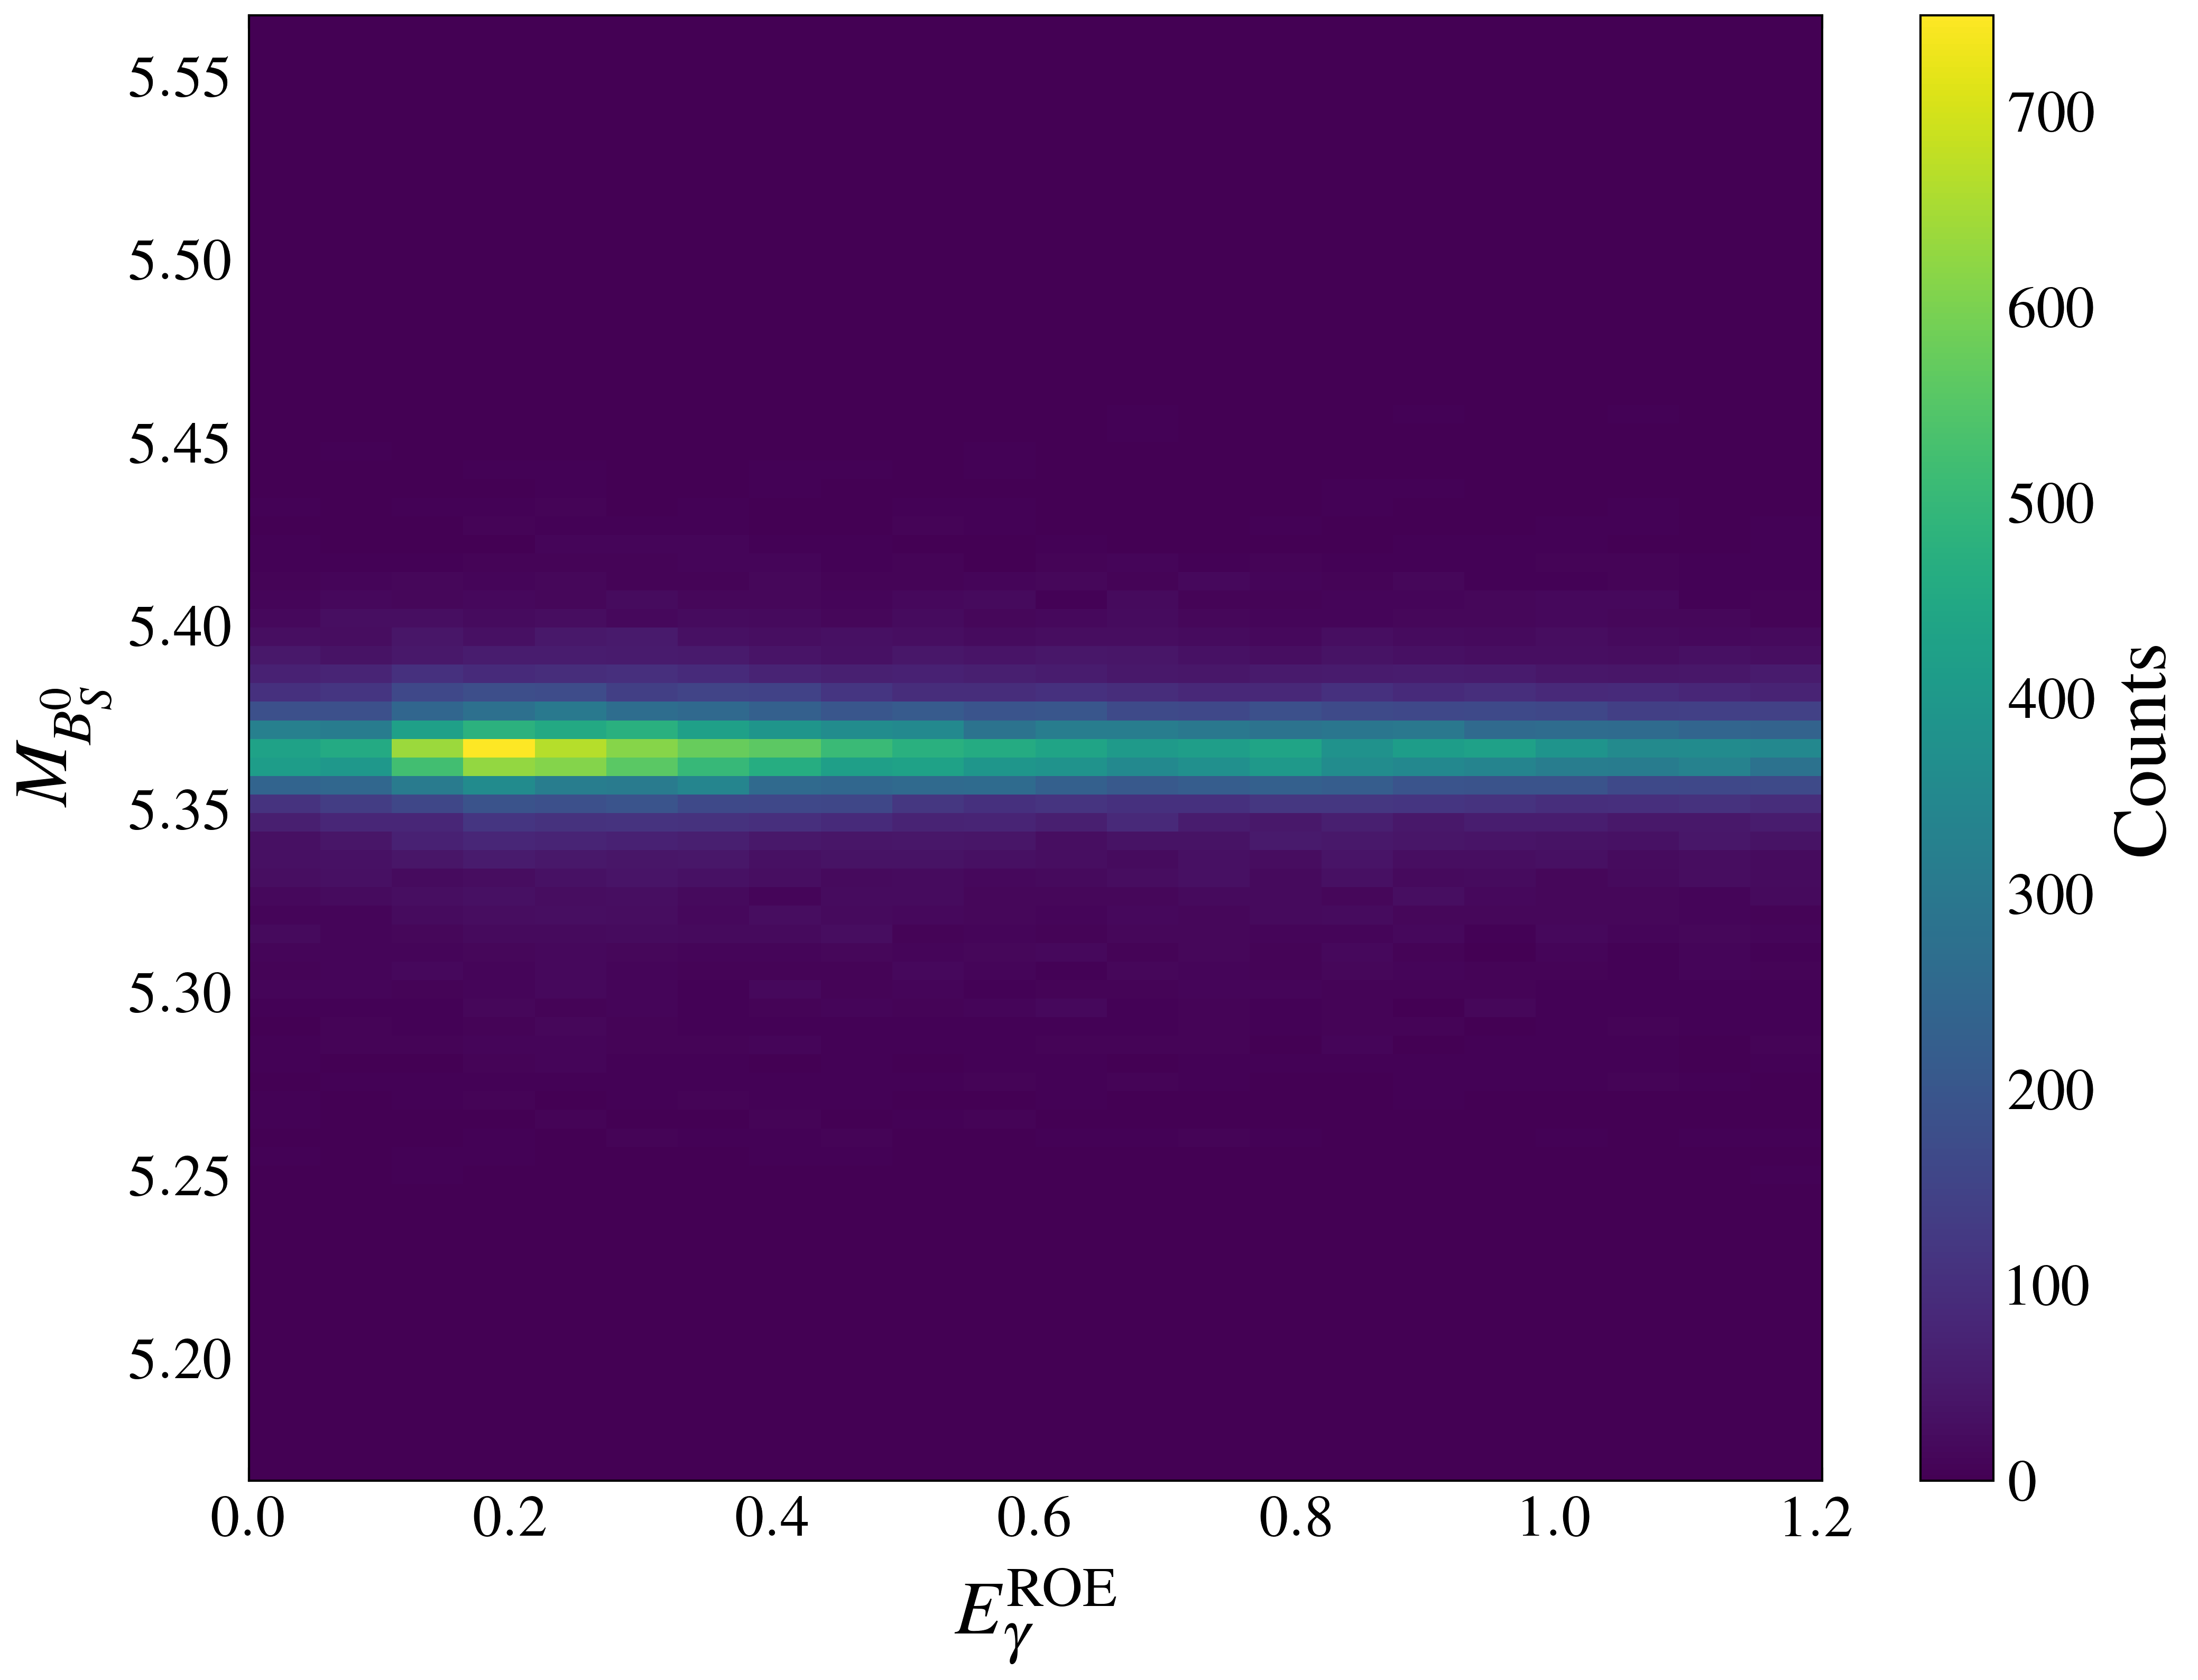

In [117]:

bin_centers, counts, N = compute_nd_histogram(lep, [bins_x, bins_y], ["E_gamma_in_ROE", "M0"], filter_mask = mask & mask_lep & (pc.field("is0") == 1))

plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(*bin_centers, counts)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_S^0}$")
plt.colorbar(pmesh, label="Counts")
plt.show()

In [118]:
def get_values_from_nd_histogram(
    bin_centers: List[np.ndarray],
    hist_counts: np.ndarray,
    x: Union[List[np.ndarray], np.ndarray]
) -> np.ndarray:
    dims = len(bin_centers)
    if len(x) != dims:
        raise ValueError(f"Число координат x ({len(x)}) не совпадает с размерностью ({dims})")

    x = [np.asarray(xi) for xi in x]
    shape = x[0].shape
    for xi in x:
        if xi.shape != shape:
            raise ValueError("Все массивы координат должны иметь одинаковую форму")

    indices = []
    for i, xi in enumerate(x):
        centers_1d = np.unique(bin_centers[i])  # Просто уникальные значения по оси
        idx = np.abs(centers_1d[None, :] - xi[..., None]).argmin(axis=-1)
        indices.append(idx)

    return hist_counts[tuple(indices)]


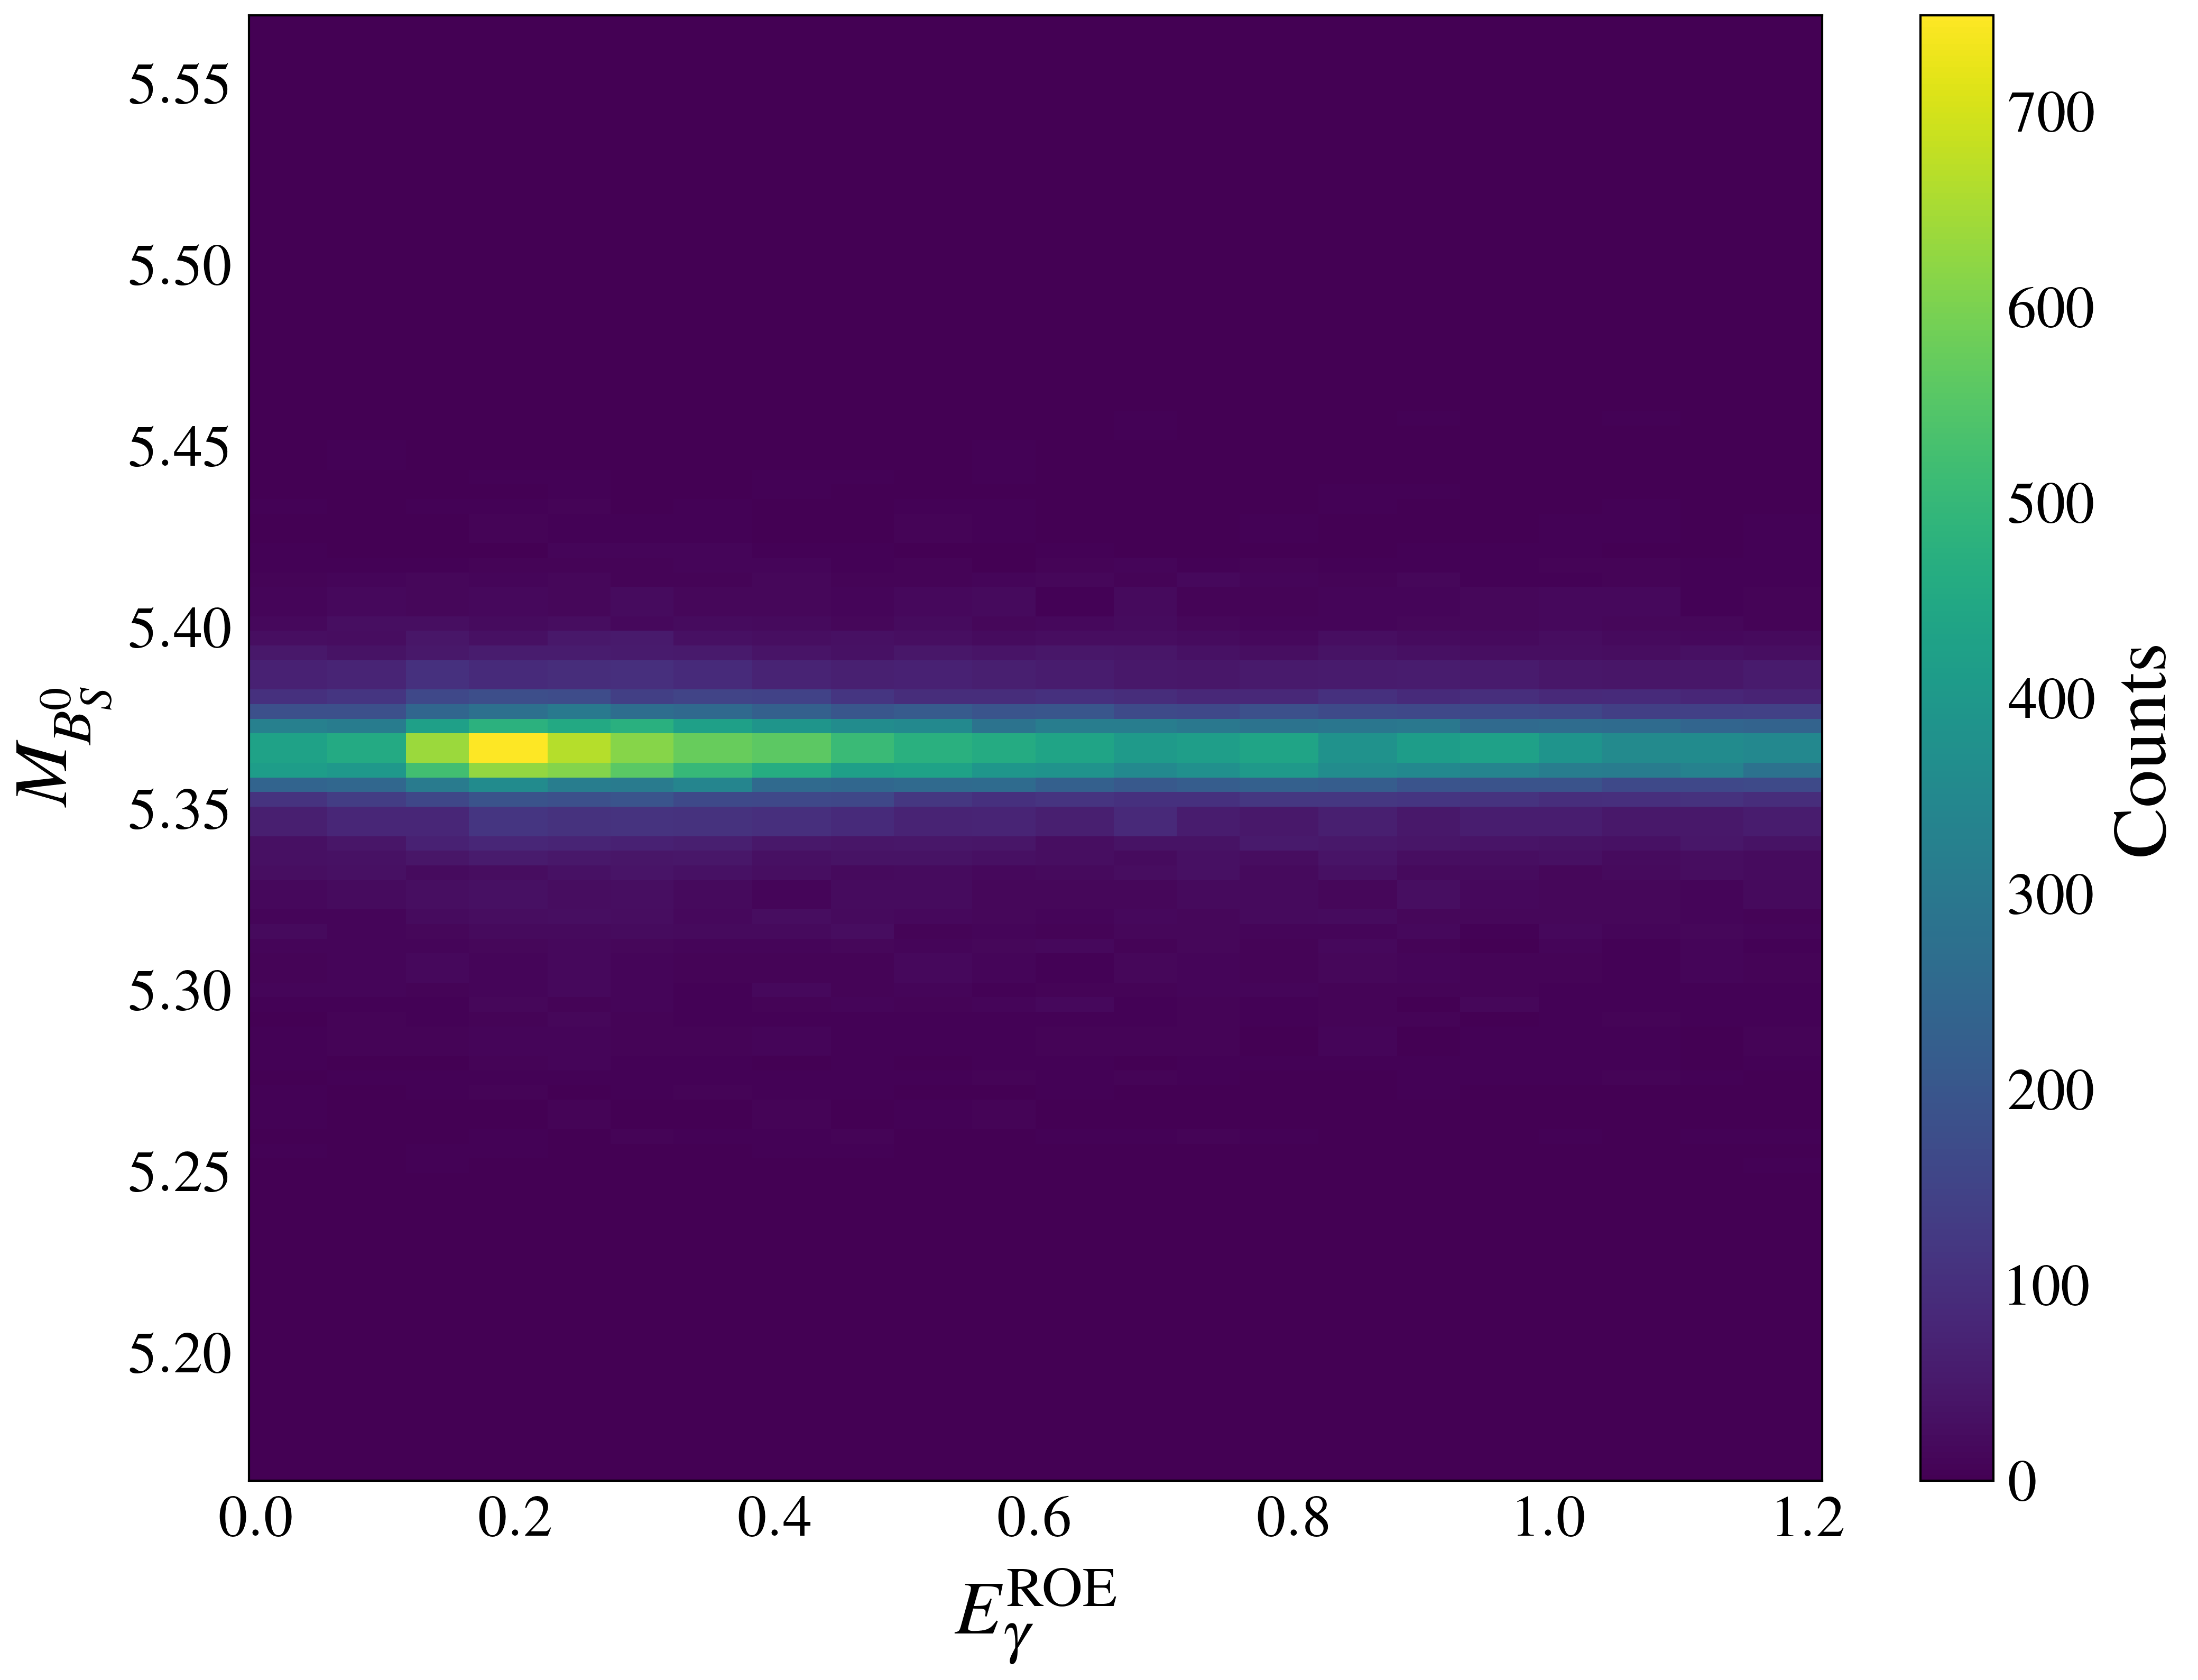

In [125]:
x = np.linspace(0, 1.2, 100)
y = np.linspace(BS0 - 0.2, BS0 + 0.2, 100)
X, Y = np.meshgrid(x, y, indexing='ij')
val = get_values_from_nd_histogram(bin_centers, counts, [X, Y])

plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(X, Y, val)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_S^0}$")
plt.colorbar(pmesh, label="Counts")
plt.show()

In [126]:
X = np.array([bc.flatten() for bc in bin_centers]).T 
y = counts.flatten()
from xgboost import XGBRegressor

reg = XGBRegressor(n_estimators=100, max_depth=10)
reg.fit(X, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [127]:
X

array([[0.02727273, 5.16922265],
       [0.02727273, 5.17428594],
       [0.02727273, 5.17934923],
       ...,
       [1.17272727, 5.55403277],
       [1.17272727, 5.55909606],
       [1.17272727, 5.56415935]], shape=(1738, 2))

In [128]:
x = np.linspace(0, 1.2, 100)
y = np.linspace(BS0 - 0.2, BS0 + 0.2, 100)
X_grid, Y_grid = np.meshgrid(x, y, indexing='ij')
N_points = X_grid.size

X_input = np.zeros((N_points, X.shape[1]))
X_input[:, 0] = X_grid.flatten()
X_input[:, 1] = Y_grid.flatten()

y_pred = reg.predict(X_input)
counts_pred = y_pred.reshape(X_grid.shape)

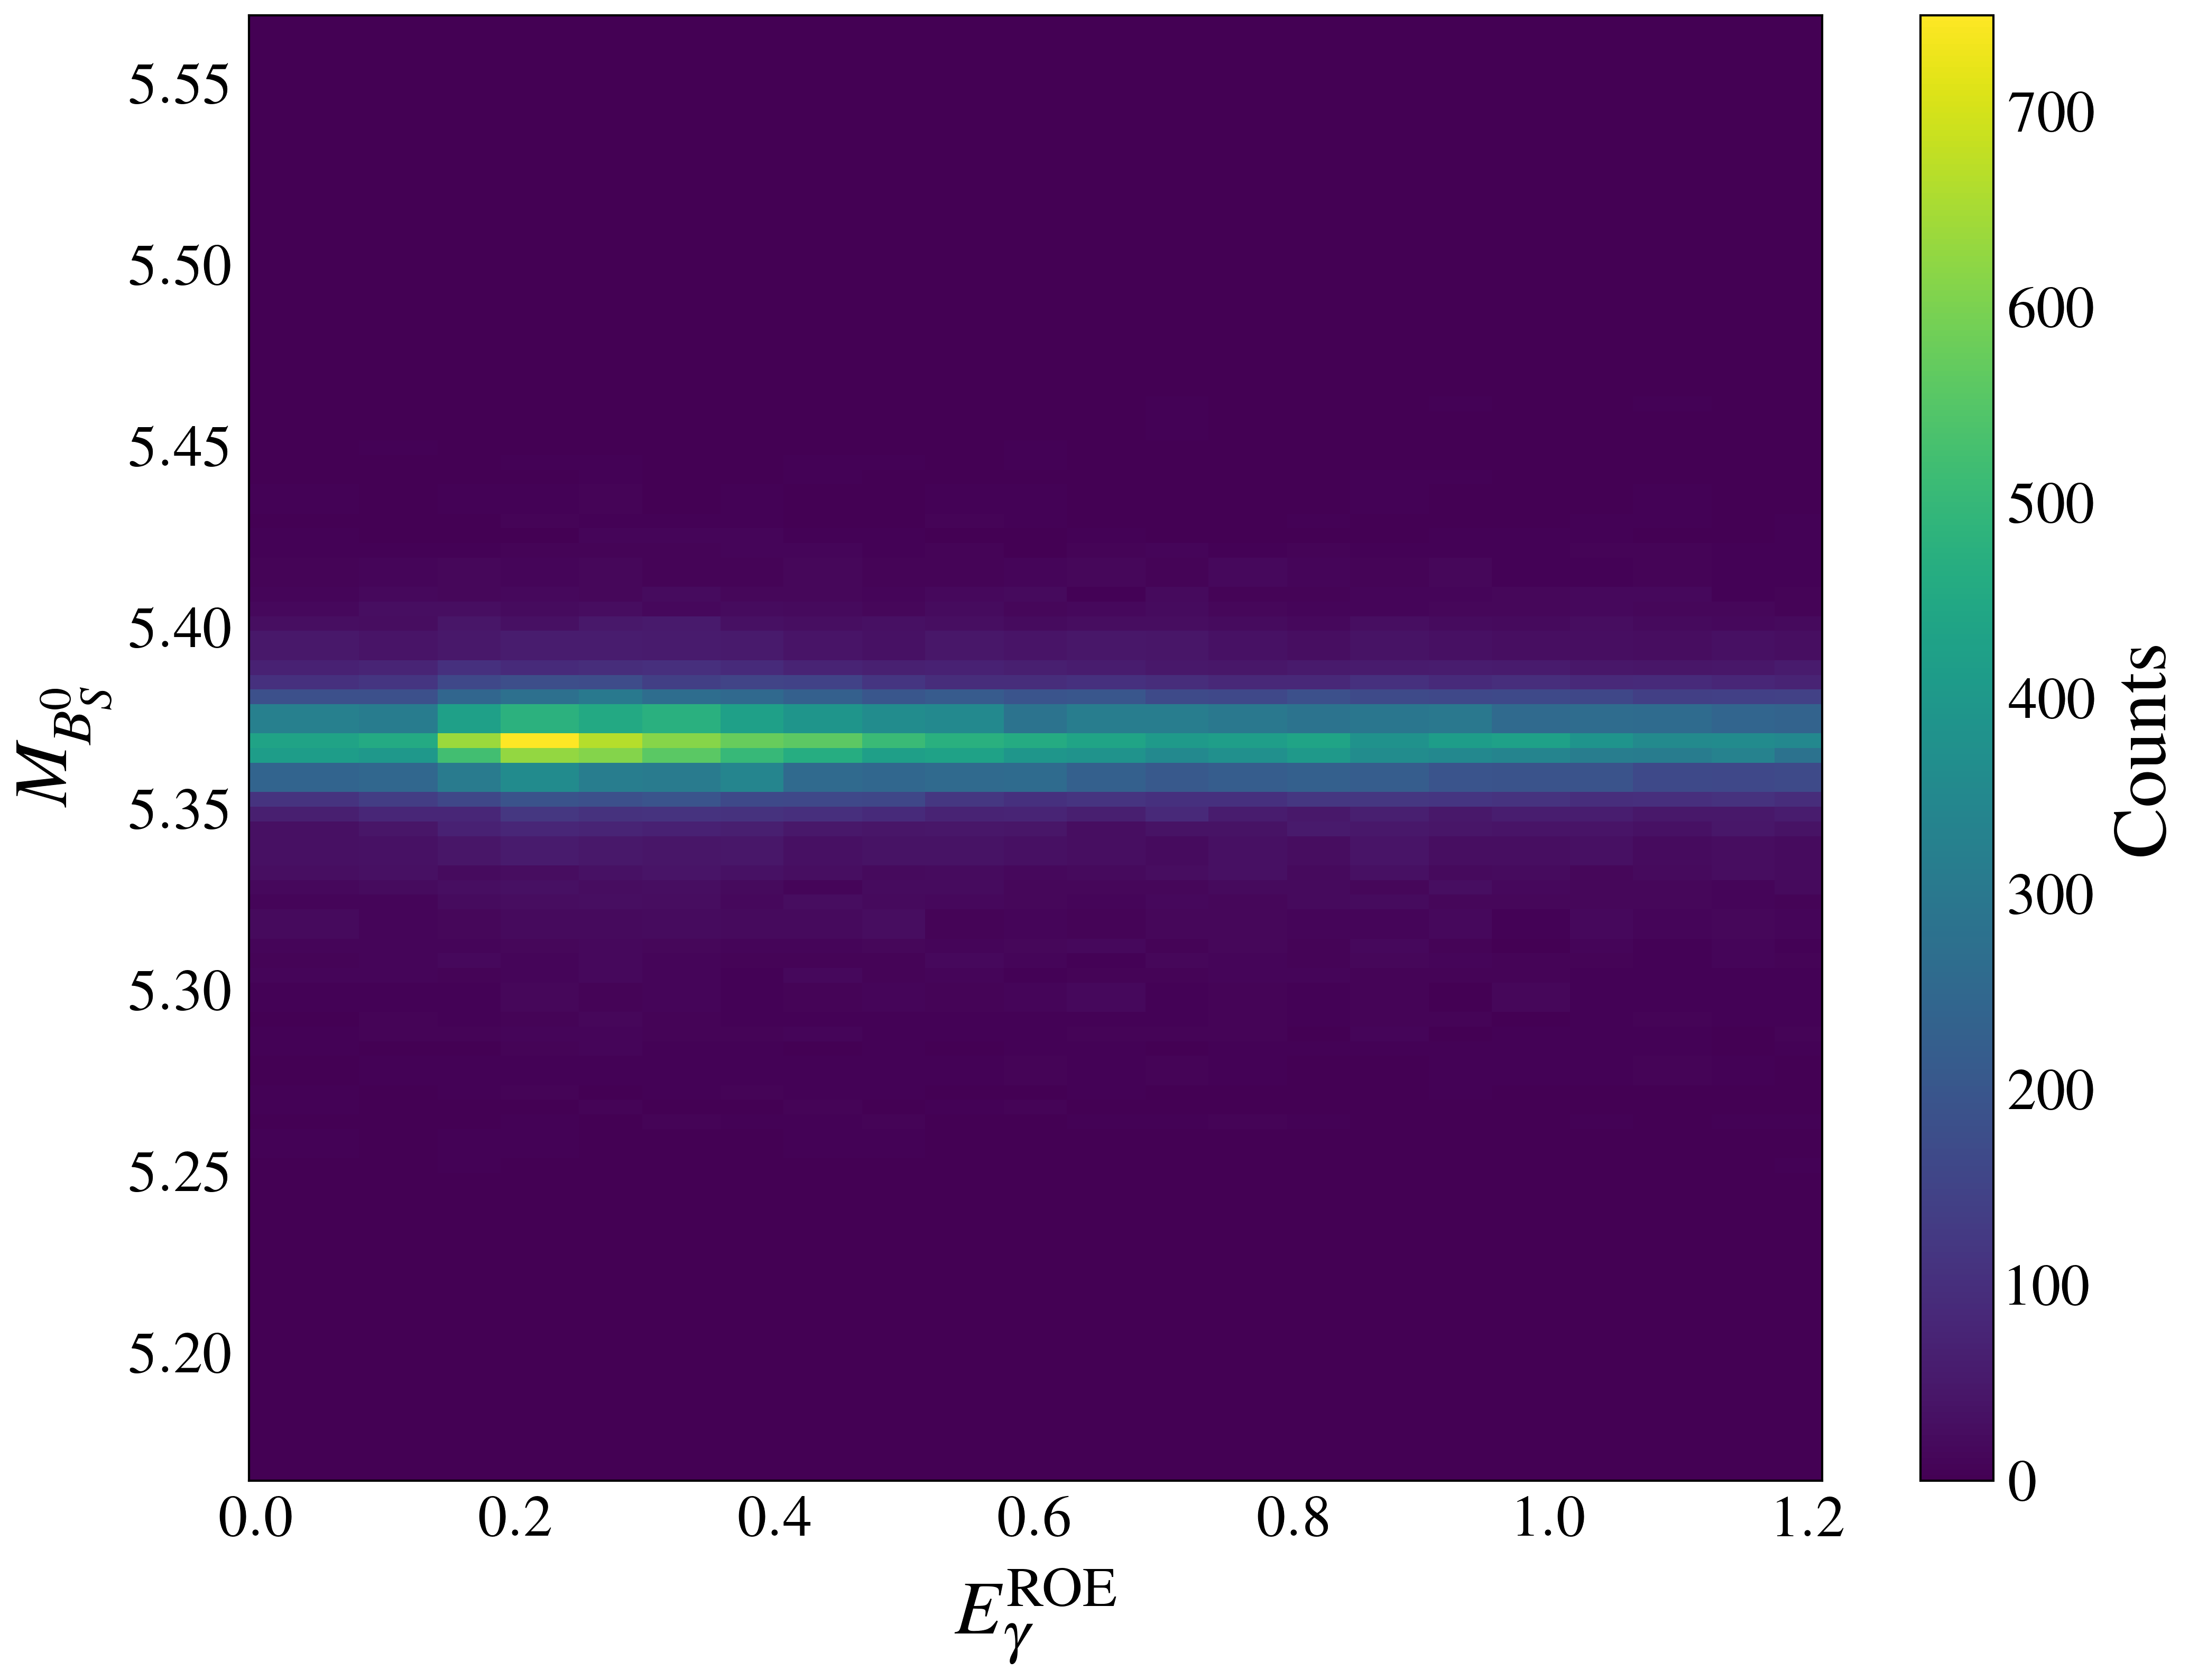

In [129]:
plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(X_grid, Y_grid, counts_pred, shading='auto')
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_S^0}$")
plt.colorbar(pmesh, label="Counts")
plt.show()

In [124]:
reg.save_model("bsbs.json")